# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from farasa.stemmer import FarasaStemmer
import gensim
from nltk.tokenize import RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import emojis

import helper

# Read and Clean 

In [2]:
df_train = pd.read_csv(r"data/ArSarcasm_train.csv")
df_test = pd.read_csv(r"data/ArSarcasm_test.csv")

In [3]:
stemmer =  FarasaStemmer(interactive=True)

[2021-06-30 01:18:55,889 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [4]:
df_train['cleaned_tweet'] = df_train['tweet'].apply(helper.clean_tweet)
df_test['cleaned_tweet'] = df_test['tweet'].apply(helper.clean_tweet)

In [5]:
df_train['cleaned_tweet'] = df_train['cleaned_tweet'].apply(lambda x: stemmer.stem(x))
df_test['cleaned_tweet'] = df_test['cleaned_tweet'].apply(lambda x: stemmer.stem(x))

# Remove stopwords

In [6]:
df_train["cleaned_tweet"] = df_train["cleaned_tweet"].apply(helper.remove_stopWords)
df_test["cleaned_tweet"] = df_test["cleaned_tweet"].apply(helper.remove_stopWords)

# Build our Vocab List

In [7]:
vocab = []
for tw in df_train['cleaned_tweet']:
    for word in tw.split():
        if word not in vocab:
            vocab.append(word)

vocab = sorted(vocab)

In [8]:
print(len(vocab))

17355


# Prepare Data to Train

In [9]:
train_data = df_train[['sarcasm', 'cleaned_tweet']]
test_data = df_test[['sarcasm', 'cleaned_tweet']]

In [10]:
train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)

<ipython-input-10-8cb7745a2a45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sarcasm'] = train_data['sarcasm'].apply(lambda x: 1 if x==True else 0)
<ipython-input-10-8cb7745a2a45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sarcasm'] = test_data['sarcasm'].apply(lambda x: 1 if x==True else 0)


In [11]:
train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
X_train = train_data['cleaned_tweet']
X_test = test_data['cleaned_tweet']
y_train = train_data['sarcasm'].tolist()
y_test = test_data['sarcasm'].tolist()

print('Size of train data: {}'.format(len(X_train)))
print('Size of test data: {}'.format(len(X_test)))
print('Size of train labels: {}'.format(len(y_train)))
print('Size of test labels: {}'.format(len(y_test)))

Size of train data: 10163
Size of test data: 2980
Size of train labels: 10163
Size of test labels: 2980


<ipython-input-11-9b13ab82f2b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(inplace=True)
<ipython-input-11-9b13ab82f2b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(inplace=True)


## Embedding Visualization

### Bag of Word (BOW)

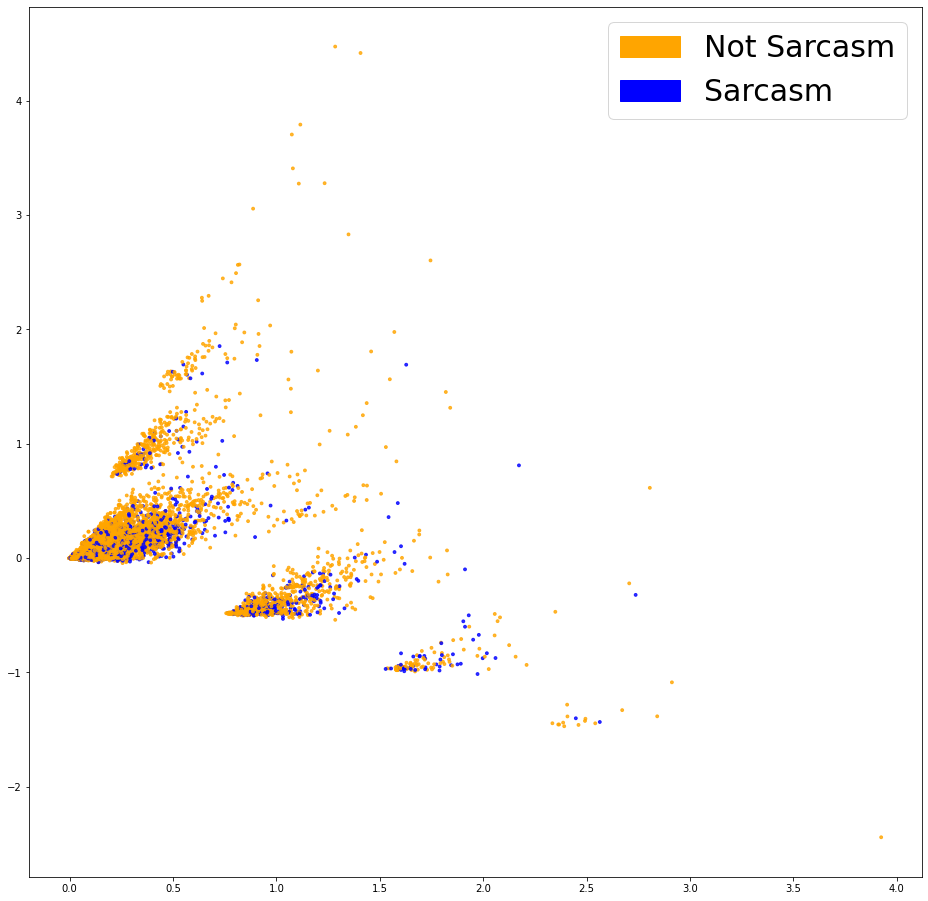

In [12]:
X_train_bow_emb, count_vectorizer = helper.bow_emb(X_train)
X_test_bow_emb = count_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(X_train_bow_emb, y_train)
plt.show()

### TF-IDF

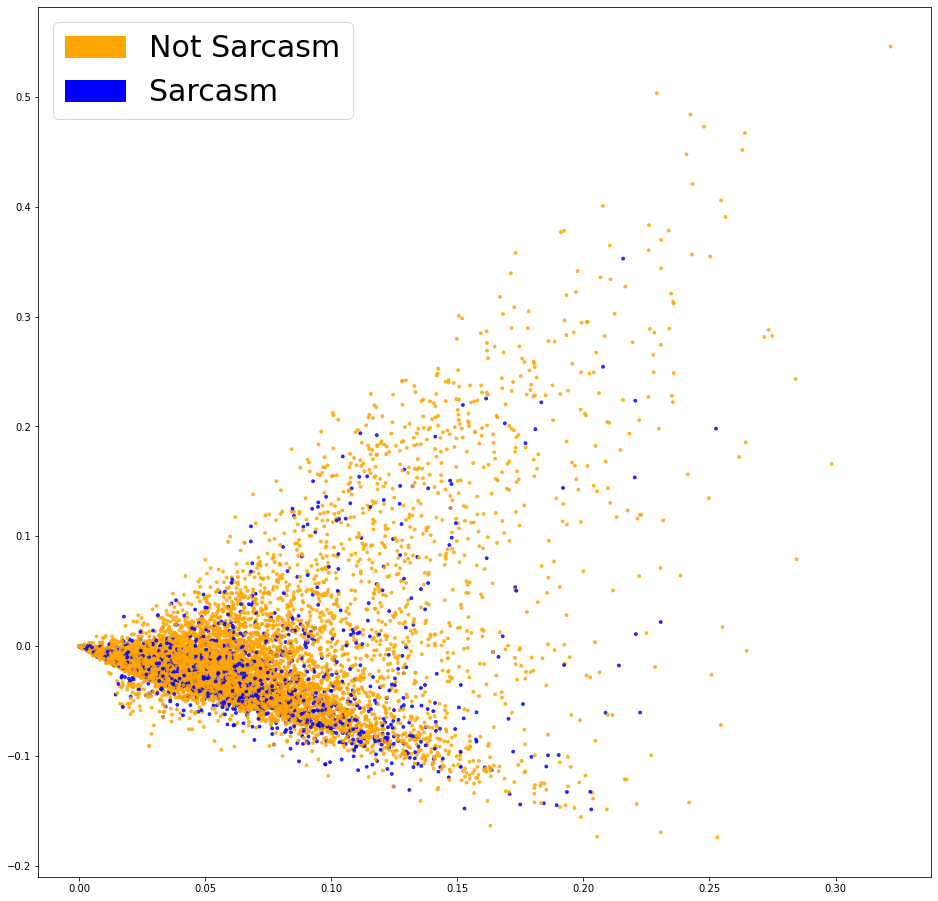

In [13]:
X_train_tfidf_emb, tfidf_vectorizer = helper.tfidf(X_train)
X_test_tfidf_emb = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(X_train_tfidf_emb, y_train)
plt.show()

### Pre-trained Word2Vec Model

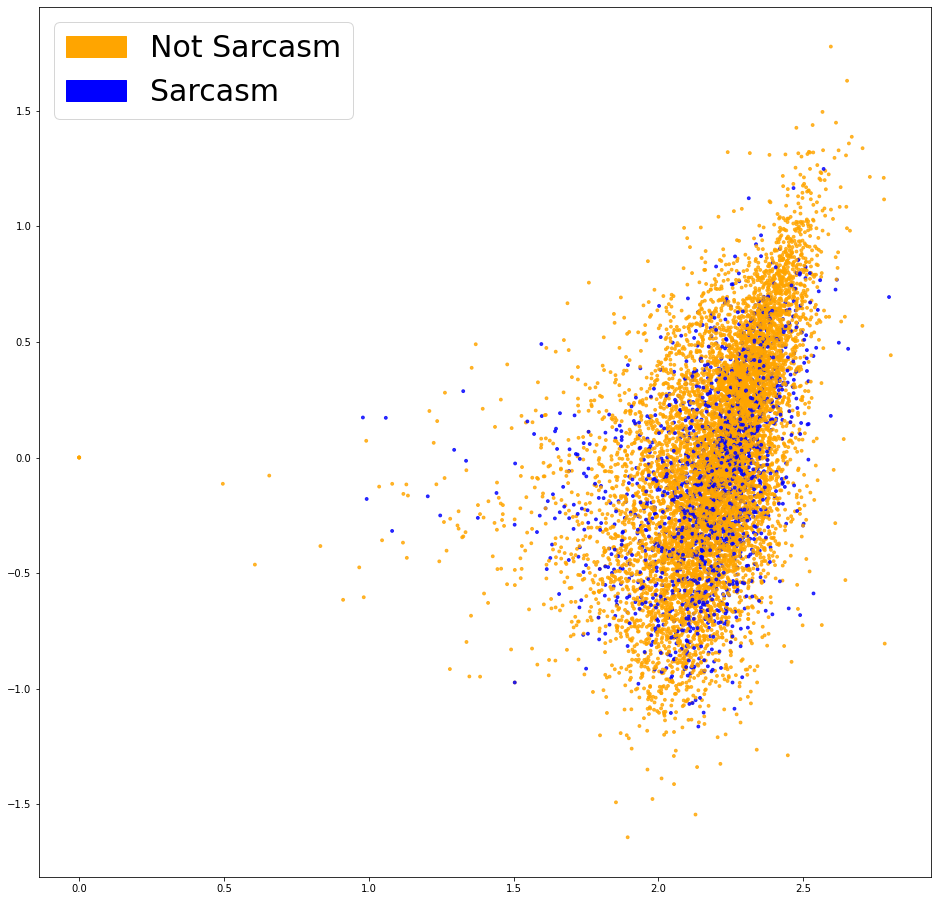

In [14]:
word2vec_path = "sg_100.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True, unicode_errors='ignore')   

tokenizer = RegexpTokenizer(r'\w+')
X_train_tokens = train_data['cleaned_tweet'].apply(tokenizer.tokenize)
X_test_tokens = test_data['cleaned_tweet'].apply(tokenizer.tokenize)

train_embeddings = helper.get_word2vec_embeddings(model, X_train_tokens)
test_embeddings = helper.get_word2vec_embeddings(model, X_test_tokens)

fig = plt.figure(figsize=(16, 16))          
helper.plot_LSA(train_embeddings, y_train)
plt.show()

## Train Models

### Logistic Regression with BOW

The f1 score for the training data: 0.9095449500554939
The precision score for the training data: 0.8379345603271984
The recall score for the training data: 0.9945388349514563
The accuracy score for the training data: 0.967922857423989
**************************************************
The f1 score for the testing data: 0.4486842105263158
The precision score for the testing data: 0.48575498575498577
The recall score for the testing data: 0.41687041564792177
The accuracy score for the testing data: 0.7187919463087248


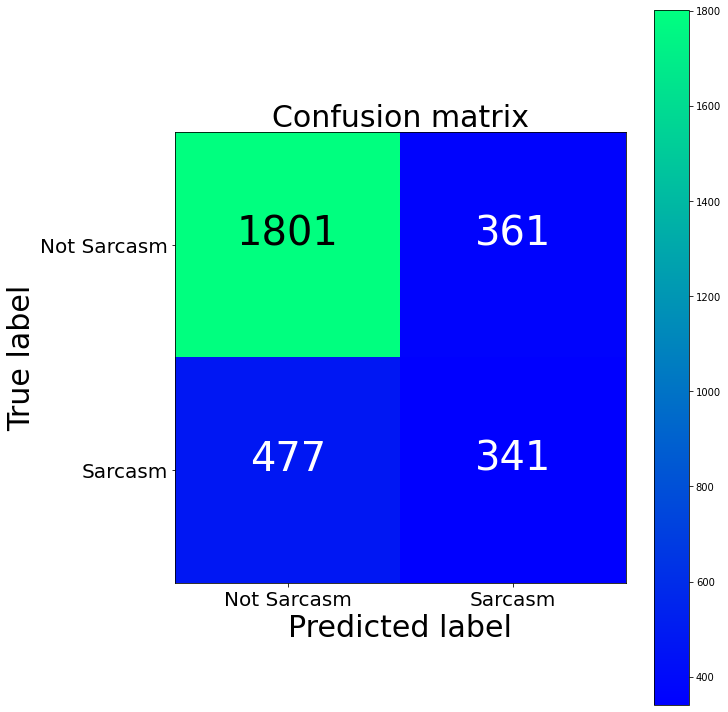

In [17]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_bow.fit(X_train_bow_emb, y_train)
pred_train = lr_bow.predict(X_train_bow_emb)

helper.print_train_scores(y_train, pred_train)

print('*'*50)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


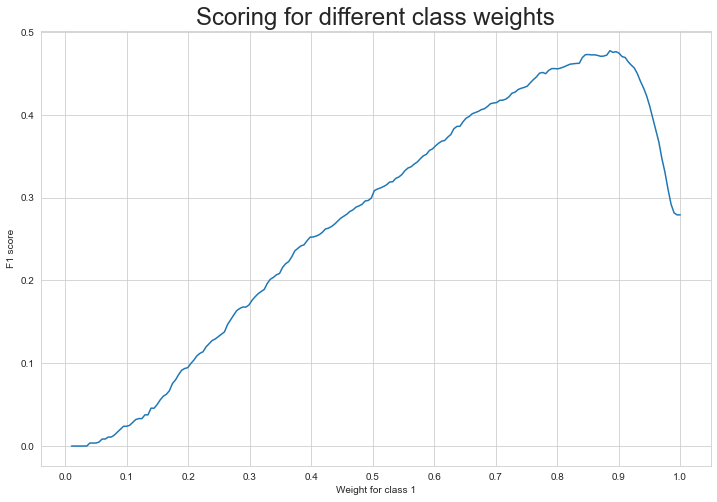

In [18]:
lr_bow = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_bow, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the training data: 0.7229504554543436
The precision score for the training data: 0.5702769015071855
The recall score for the training data: 0.9872572815533981
The accuracy score for the training data: 0.8773000098396143
**************************************************
The f1 score for the testing data: 0.4962243797195254
The precision score for the testing data: 0.444015444015444
The recall score for the testing data: 0.5623471882640587
The accuracy score for the testing data: 0.6865771812080537


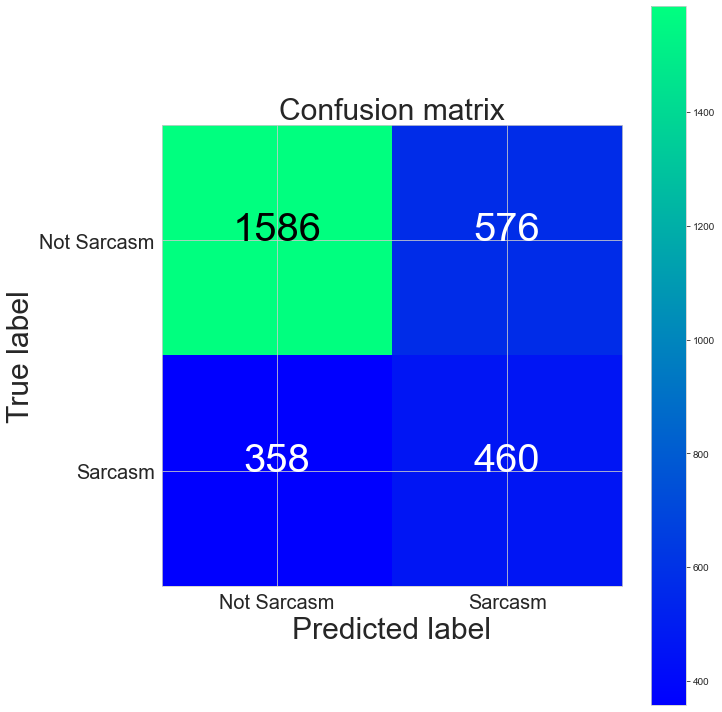

In [19]:
lr_bow = LogisticRegression(solver='newton-cg', class_weight = gridsearch.best_params_['class_weight'])
lr_bow.fit(X_train_bow_emb, y_train)
pred_train = lr_bow.predict(X_train_bow_emb)

helper.print_train_scores(y_train, pred_train)

print('*'*50)

# Predicting on the test data
pred_test = lr_bow.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

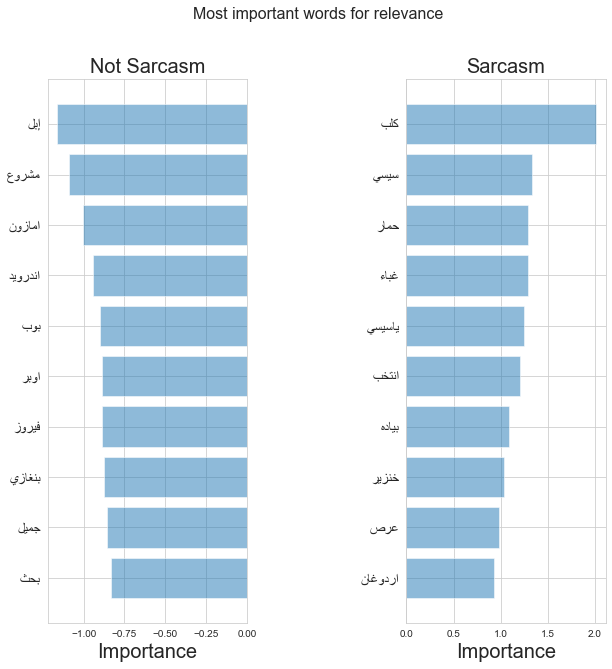

In [20]:
importance = helper.get_most_important_features(count_vectorizer, lr_bow, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

helper.plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### Logistic Regression with TF-IDF

The f1 score for the training data: 0.7544279559597894
The precision score for the training data: 0.6229249011857707
The recall score for the training data: 0.9563106796116505
The accuracy score for the training data: 0.8990455574141494
**************************************************
The f1 score for the testing data: 0.47113163972286376
The precision score for the testing data: 0.44638949671772427
The recall score for the testing data: 0.49877750611246946
The accuracy score for the testing data: 0.6926174496644295


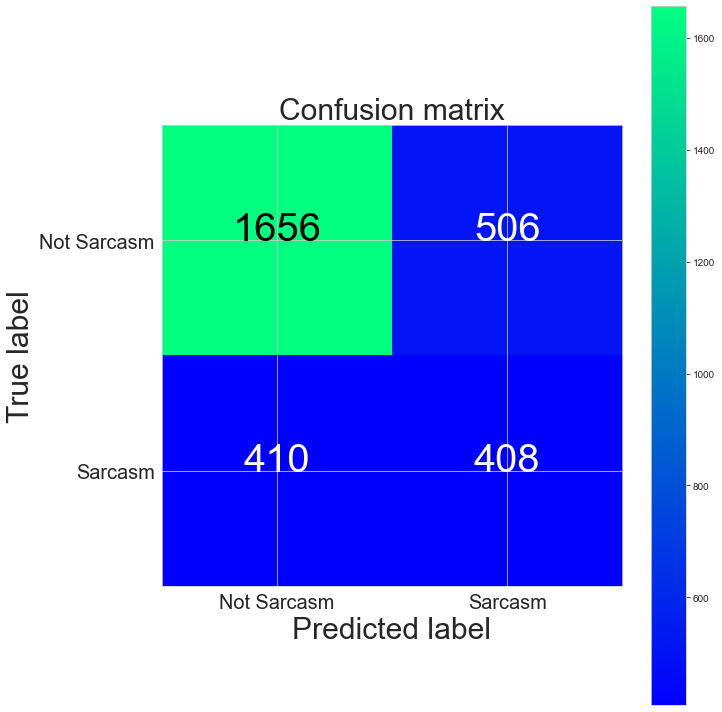

In [21]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_tfidf.fit(X_train_tfidf_emb, y_train)
pred_train = lr_tfidf.predict(X_train_tfidf_emb)

helper.print_train_scores(y_train, pred_train)

print('*'*50)


# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


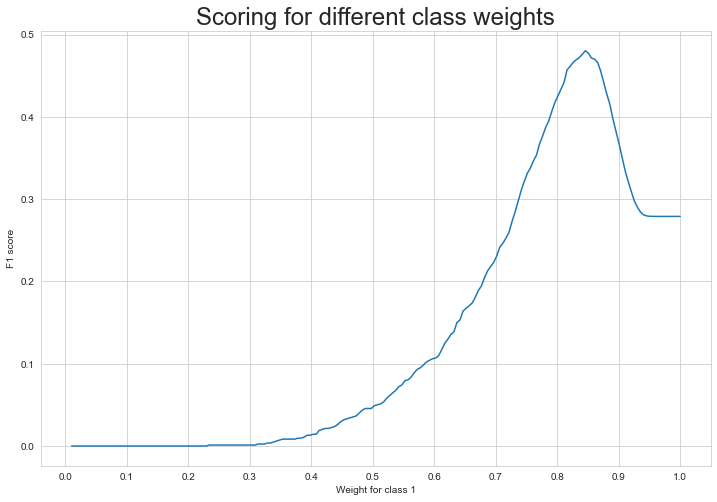

In [22]:
lr_tfidf = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_tfidf, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tfidf_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the training data: 0.6509106678230703
The precision score for the training data: 0.5064102564102564
The recall score for the training data: 0.9108009708737864
The accuracy score for the training data: 0.8415822099773689
**************************************************
The f1 score for the testing data: 0.4741951967296883
The precision score for the testing data: 0.4073748902546093
The recall score for the testing data: 0.5672371638141809
The accuracy score for the testing data: 0.6546979865771813


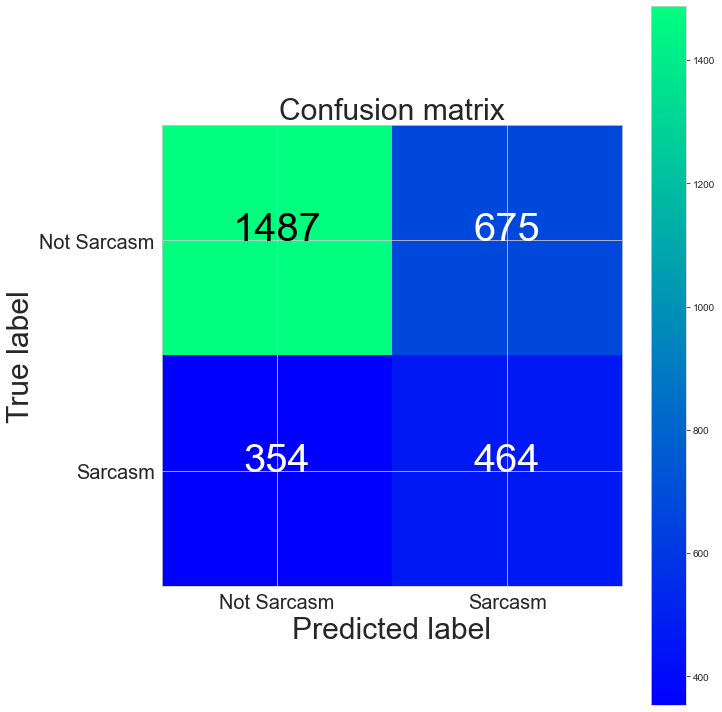

In [24]:
lr_tfidf = LogisticRegression(solver='newton-cg', class_weight = gridsearch.best_params_['class_weight'])
lr_tfidf.fit(X_train_tfidf_emb, y_train)

pred_train = lr_tfidf.predict(X_train_tfidf_emb)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

# Predicting on the test data
pred_test = lr_tfidf.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

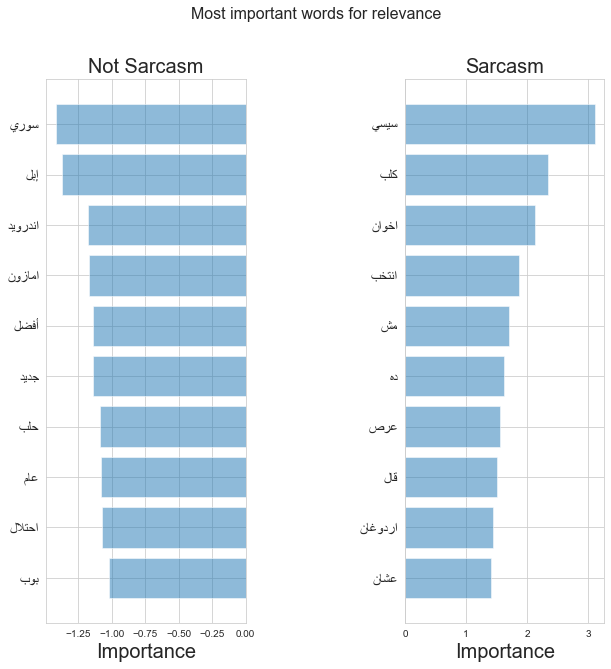

In [25]:
importance = helper.get_most_important_features(tfidf_vectorizer, lr_tfidf, 10)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

helper.plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### Logistic Regression with W2V Pre-trained Embeddings

The f1 score for the training data: 0.5453410981697171
The precision score for the training data: 0.414873417721519
The recall score for the training data: 0.7955097087378641
The accuracy score for the training data: 0.784906031683558
**************************************************
The f1 score for the testing data: 0.510909090909091
The precision score for the testing data: 0.40665701881331406
The recall score for the testing data: 0.687041564792176
The accuracy score for the testing data: 0.6389261744966444


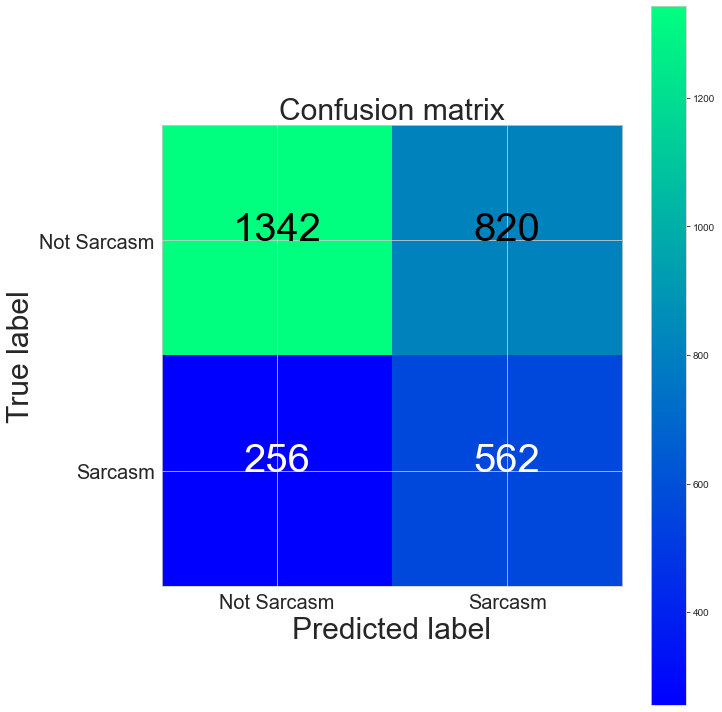

In [26]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr_w2v.fit(train_embeddings, y_train)

pred_train = lr_w2v.predict(train_embeddings)
helper.print_train_scores(y_train, pred_train)
print('*'*50)


# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


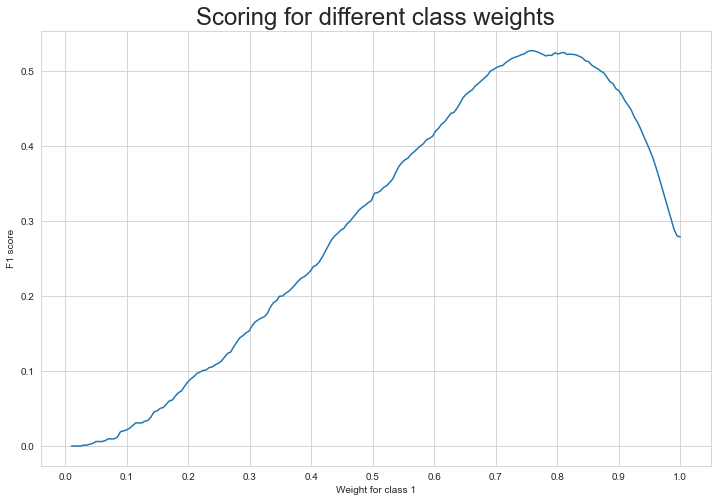

In [27]:
lr_w2v = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr_w2v, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the training data: 0.5602487691111687
The precision score for the training data: 0.4889190411578471
The recall score for the training data: 0.6559466019417476
The accuracy score for the training data: 0.8330217455475746
**************************************************
The f1 score for the testing data: 0.47403314917127076
The precision score for the testing data: 0.4324596774193548
The recall score for the testing data: 0.5244498777506112
The accuracy score for the testing data: 0.6805369127516778


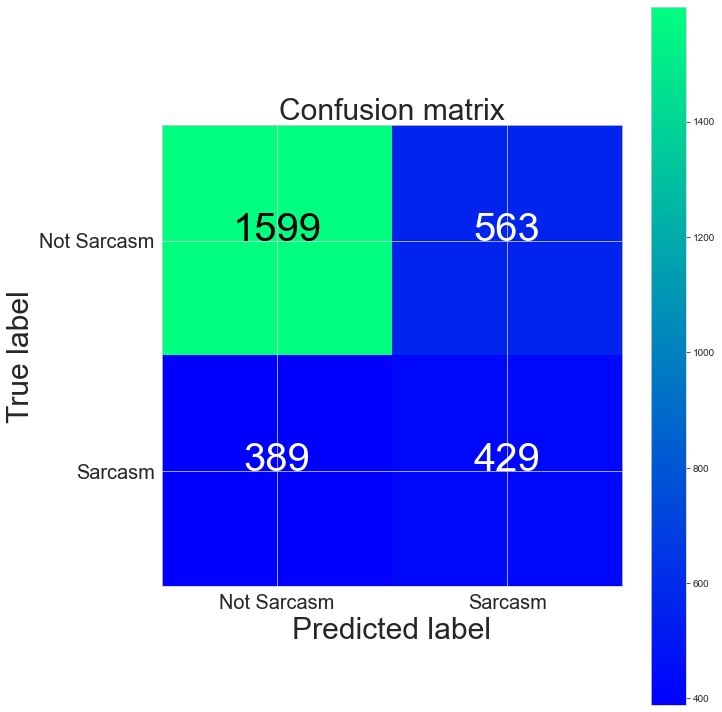

In [30]:
lr_w2v = LogisticRegression(solver='newton-cg', class_weight=gridsearch.best_params_['class_weight'])
lr_w2v.fit(train_embeddings, y_train)

pred_train = lr_w2v.predict(train_embeddings)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

# Predicting on the test data
pred_test = lr_w2v.predict(test_embeddings)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### SVM with BOW

The f1 score for the training data: 0.9298745724059294
The precision score for the training data: 0.8768817204301075
The recall score for the training data: 0.9896844660194175
The accuracy score for the training data: 0.9757945488536849
**************************************************
The f1 score for the testing data: 0.26397800183318054
The precision score for the testing data: 0.5274725274725275
The recall score for the testing data: 0.17603911980440098
The accuracy score for the testing data: 0.7305369127516779


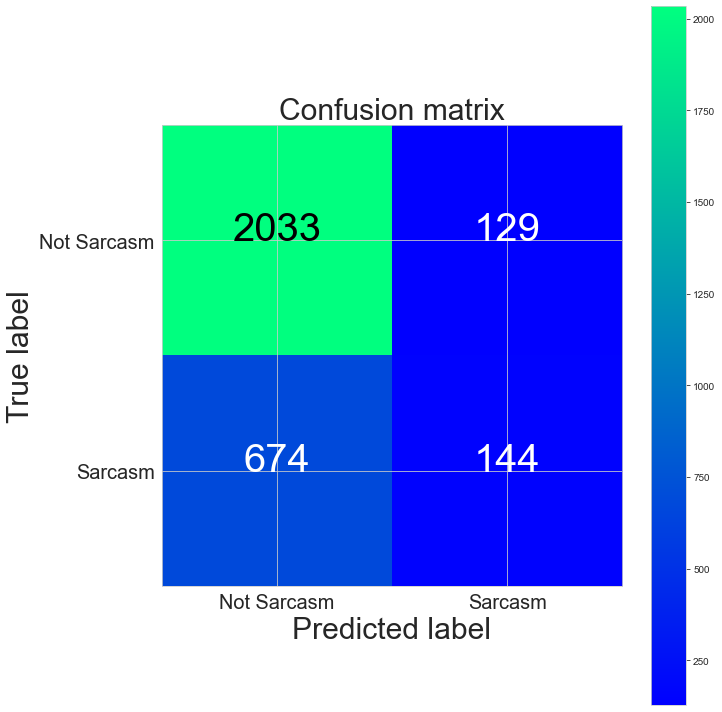

In [31]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_bow_emb, y_train)

pred_train = svm.predict(X_train_bow_emb)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

pred_test = svm.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


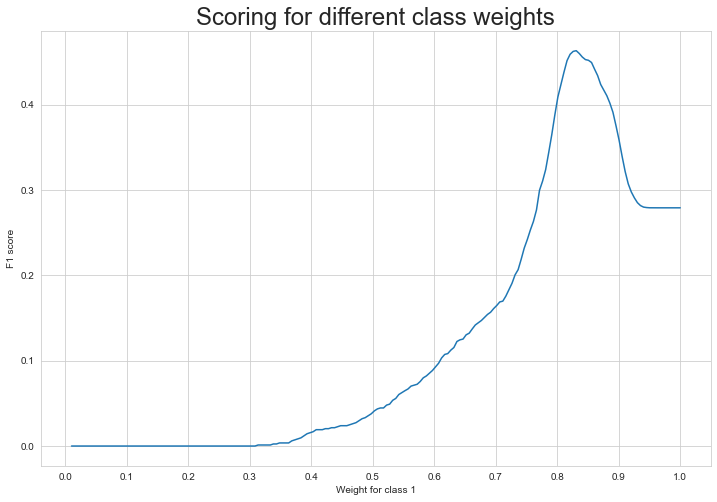

In [34]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(n_splits=5), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_bow_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the training data: 0.6990337025689372
The precision score for the training data: 0.5714836223506744
The recall score for the training data: 0.899878640776699
The accuracy score for the training data: 0.8743481255534783
**************************************************
The f1 score for the testing data: 0.493771234428086
The precision score for the testing data: 0.459915611814346
The recall score for the testing data: 0.5330073349633252
The accuracy score for the testing data: 0.7


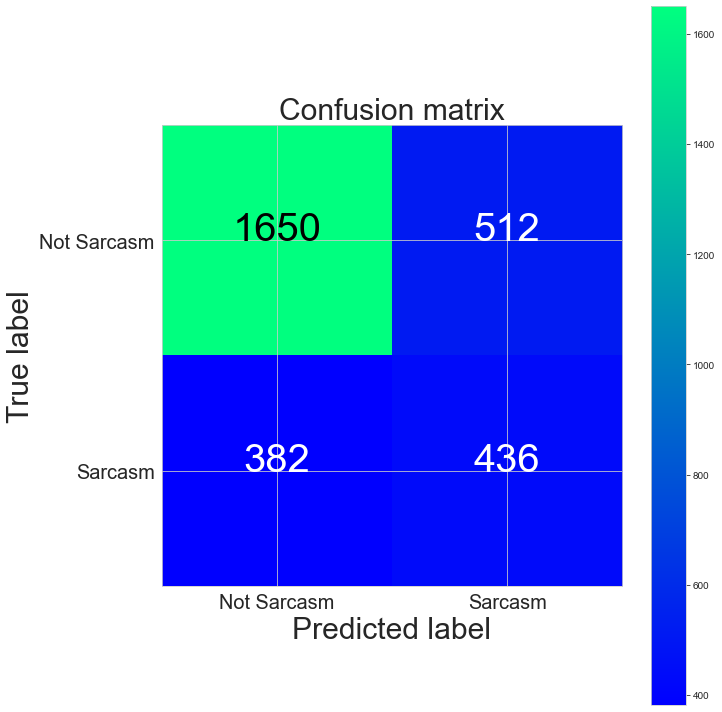

In [35]:
svm = SVC(class_weight=gridsearch.best_params_['class_weight'])
svm.fit(X_train_bow_emb, y_train)

pred_train = svm.predict(X_train_bow_emb)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

# Predicting on the test data
pred_test = svm.predict(X_test_bow_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### SVM with TF-IDF

The f1 score for the training data: 0.9573046761545163
The precision score for the training data: 0.9181058495821727
The recall score for the training data: 1.0
The accuracy score for the training data: 0.9855357669979337
**************************************************
The f1 score for the testing data: 0.28493150684931506
The precision score for the testing data: 0.5631768953068592
The recall score for the testing data: 0.19070904645476772
The accuracy score for the testing data: 0.737248322147651


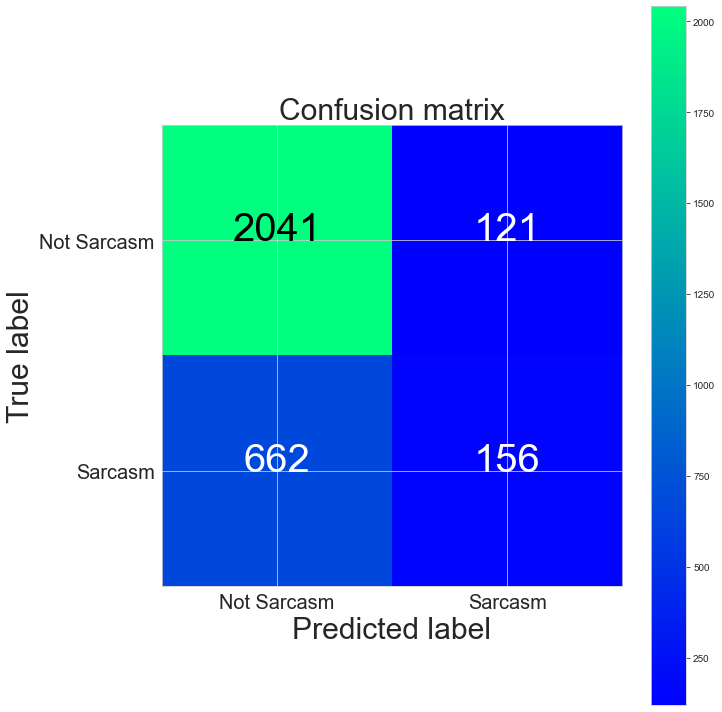

In [37]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_tfidf_emb, y_train)

pred_train = svm.predict(X_train_tfidf_emb)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


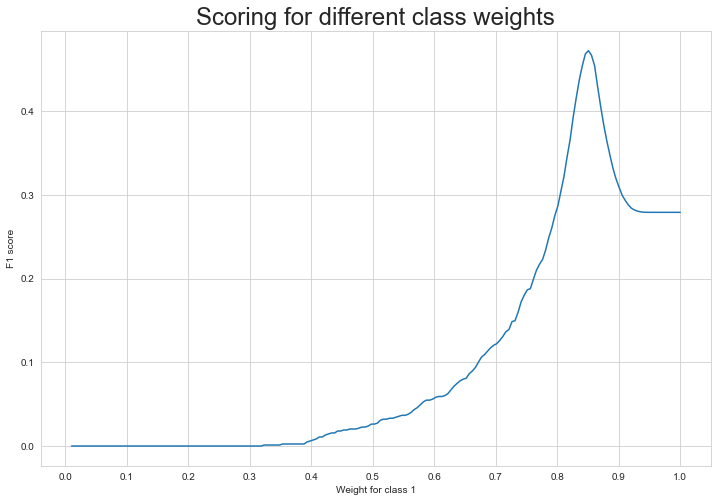

In [40]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train_tfidf_emb, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the training data: 0.7253380625138549
The precision score for the training data: 0.5714285714285714
The recall score for the training data: 0.9927184466019418
The accuracy score for the training data: 0.8780871789825839
**************************************************
The f1 score for the testing data: 0.4697508896797153
The precision score for the testing data: 0.402088772845953
The recall score for the testing data: 0.5647921760391198
The accuracy score for the testing data: 0.65


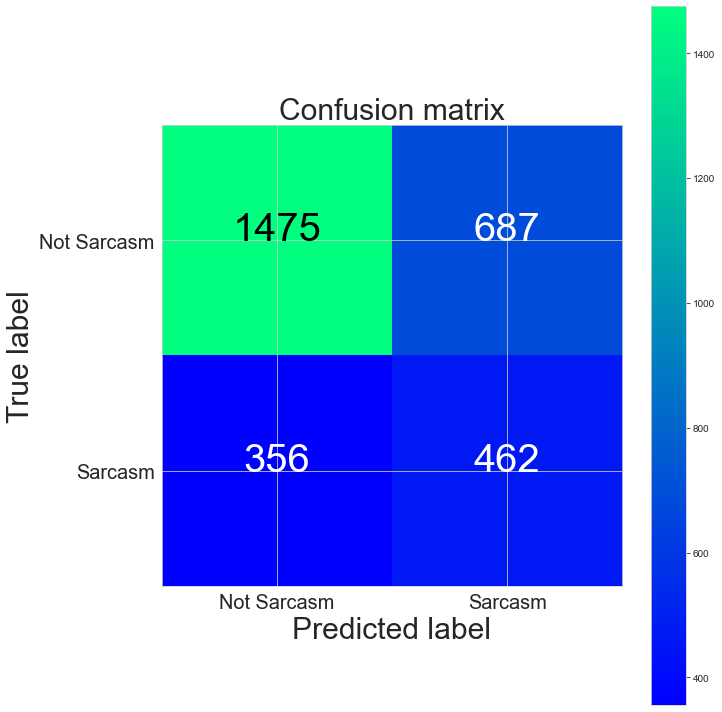

In [42]:
svm = SVC(class_weight=gridsearch.best_params_['class_weight'])
svm.fit(X_train_tfidf_emb, y_train)

pred_train = svm.predict(X_train_tfidf_emb)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

# Predicting on the test data
pred_test = svm.predict(X_test_tfidf_emb)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### SVM with W2V Pre-trained Embeddings

In [43]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
train_scaled = scalar.fit_transform(train_embeddings)
test_scaled = scalar.fit_transform(test_embeddings)

The f1 score for the training data: 0.7569590643274854
The precision score for the training data: 0.6159116863342216
The recall score for the training data: 0.9817961165048543
The accuracy score for the training data: 0.8977664075568238
**************************************************
The f1 score for the testing data: 0.5372245384157236
The precision score for the testing data: 0.5238095238095238
The recall score for the testing data: 0.5513447432762836
The accuracy score for the testing data: 0.7392617449664429


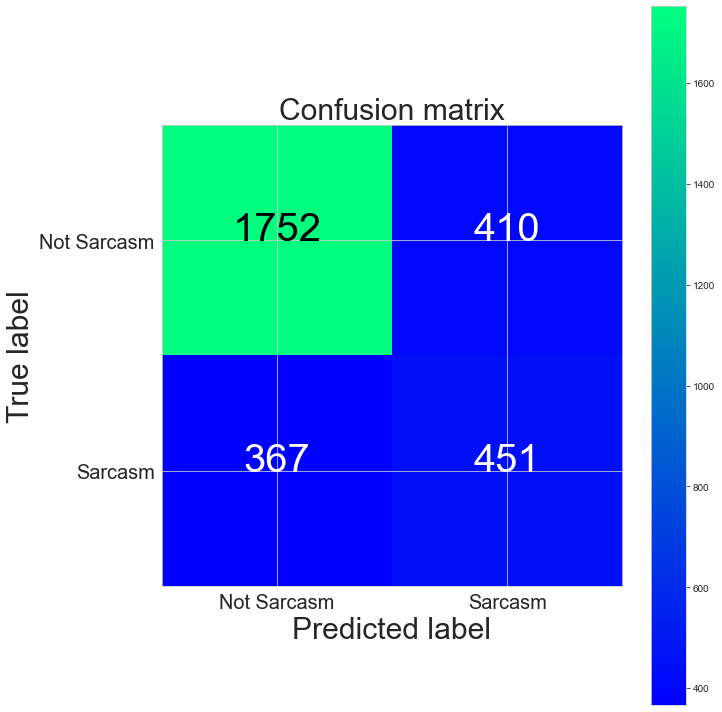

In [44]:
svm = SVC(class_weight='balanced')
svm.fit(train_scaled, y_train)

pred_train = svm.predict(train_scaled)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

pred_test = svm.predict(test_scaled)
#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

### Handel the Imbalace Manually

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\moamen\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


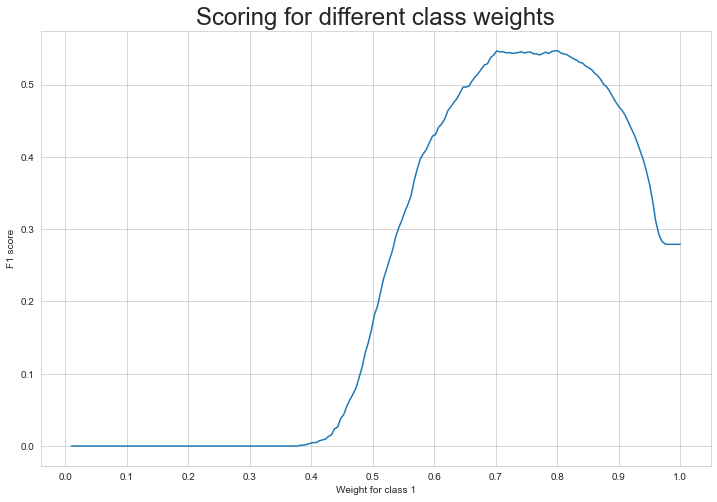

In [45]:
svm = SVC()

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= svm, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_embeddings, y_train)

#Ploting the score for different values of weight
helper.plot_score_for_weight(gridsearch, weights)

The f1 score for the training data: 0.6668255481410867
The precision score for the training data: 0.5490580847723705
The recall score for the training data: 0.8489077669902912
The accuracy score for the training data: 0.8624421922660632
**************************************************
The f1 score for the testing data: 0.5340632603406327
The precision score for the testing data: 0.5314769975786925
The recall score for the testing data: 0.5366748166259169
The accuracy score for the testing data: 0.7429530201342281


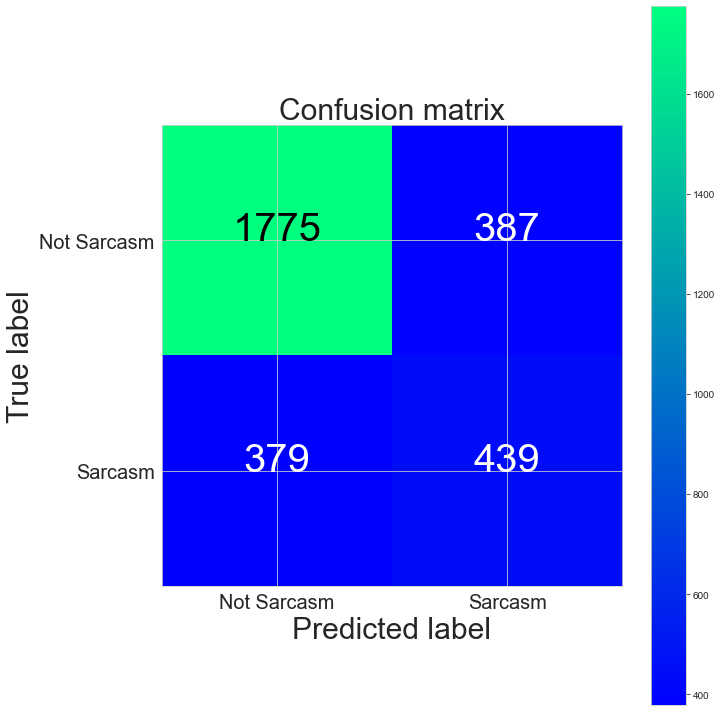

In [46]:
svm = SVC(class_weight=gridsearch.best_params_['class_weight'])
svm.fit(train_scaled, y_train)

pred_train = svm.predict(train_scaled)
helper.print_train_scores(y_train, pred_train)
print('*'*50)

# Predicting on the test data
pred_test = svm.predict(test_scaled)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

## Emojis Embedding

In [47]:
def extract_emojis(tweet):
    return list(emojis.get(tweet))

In [48]:
emo_train = df_train['tweet'].apply(extract_emojis)
emo_test = df_test['tweet'].apply(extract_emojis)

In [49]:
emoji2vec_path = "emoji2vec.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(emoji2vec_path, binary=True, unicode_errors='ignore')   


train_emo_embeddings = helper.get_word2vec_embeddings(model, emo_train)
test_emo_embeddings = helper.get_word2vec_embeddings(model, emo_test)

In [50]:
# Word_Vector o Emoji_Vector

x_train_features_concat = []
for t, e in zip(train_scaled, train_emo_embeddings):
    x_train_features_concat.append(np.concatenate((t, e), axis=0))
    
# Word_Vector + Emoji_Vector
x_train_features_sum = []
for t, e in zip(train_scaled, train_emo_embeddings):
    x_train_features_sum.append(t + e)

In [51]:
# Word_Vector o Emoji_Vector
x_test_features_concat = []
for t, e in zip(test_scaled, test_emo_embeddings):
    x_test_features_concat.append(np.concatenate((t, e), axis=0))

# Word_Vector + Emoji_Vector
x_test_features_sum = []
for t, e in zip(test_scaled, test_emo_embeddings):
    x_test_features_sum.append(t + e)

The f1 score for the training data: 0.7573133629768313
The precision score for the training data: 0.6163809523809524
The recall score for the training data: 0.9817961165048543
The accuracy score for the training data: 0.8979631998425661
**************************************************
The f1 score for the testing data: 0.5403466826060968
The precision score for the testing data: 0.5286549707602339
The recall score for the testing data: 0.5525672371638142
The accuracy score for the testing data: 0.7419463087248322


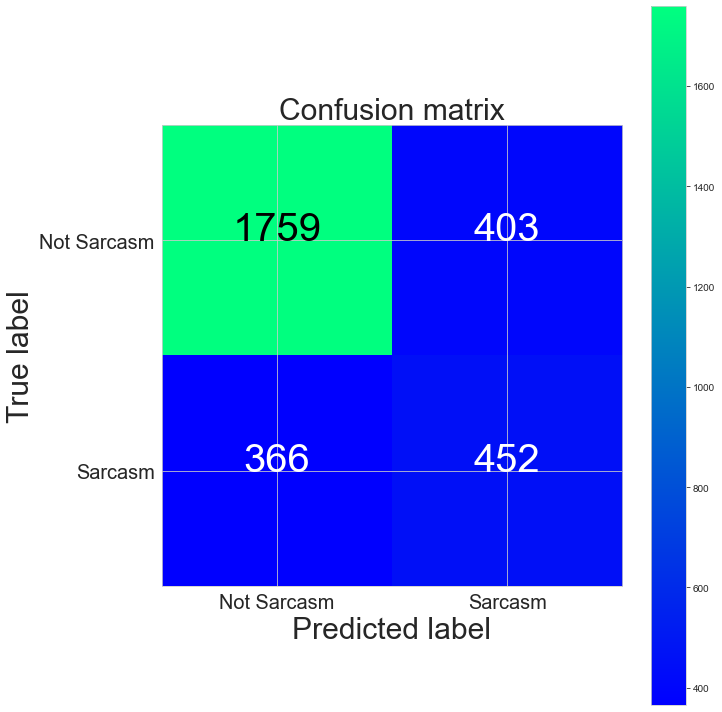

In [52]:
svm = SVC(class_weight='balanced')
svm.fit(x_train_features_sum, y_train)

pred_train = svm.predict(x_train_features_sum)
helper.print_train_scores(y_train, pred_train)
print('*'*50)


pred_test = svm.predict(x_test_features_sum)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)

The f1 score for the training data: 0.7573133629768313
The precision score for the training data: 0.6163809523809524
The recall score for the training data: 0.9817961165048543
The accuracy score for the training data: 0.8979631998425661
**************************************************
The f1 score for the testing data: 0.5384157236450268
The precision score for the testing data: 0.5249709639953543
The recall score for the testing data: 0.5525672371638142
The accuracy score for the testing data: 0.7399328859060402


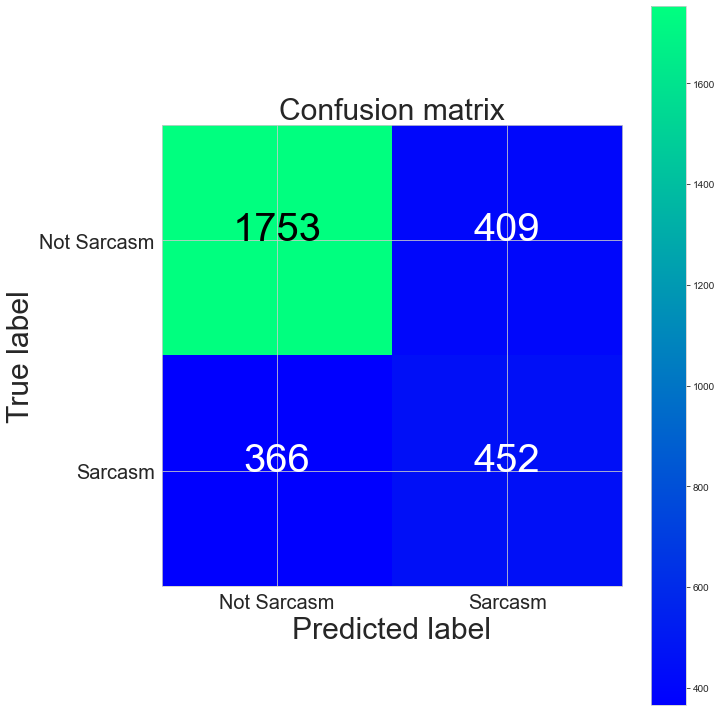

In [53]:
svm = SVC(class_weight='balanced')
svm.fit(x_train_features_concat, y_train)

pred_train = svm.predict(x_train_features_concat)
helper.print_train_scores(y_train, pred_train)
print('*'*50)


pred_test = svm.predict(x_test_features_concat)

#Calculating and printing the scores 
helper.print_test_scores(y_test, pred_test)

#Ploting the confusion matrix
helper.print_confusion_matrix(y_test, pred_test)